In [36]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split
import importlib
from causalml.metrics import plot_gain

In [37]:
#Load in Data
ace_data = pd.read_csv('C:/Users/Rehma/Downloads/ace_data.csv')

In [38]:
def preprocess_data(data, treatment, outcome, control_group_name=None, treatment_group_name=None, outcome_threshold=None):
    #Binarize the treatment and outcomes, while also changing the name of the control and treatment groups 
    data[treatment] = data[treatment].apply(lambda x: 'control' if x == control_group_name else('treatment' if x == treatment_group_name else np.nan))
    #For certain targets, such as number of mental health days, there needs to be a threshold; for this survey, values at 77, 88, and 99 correspond to no answers
    if outcome_threshold is not None:
        data[outcome] = data[outcome].apply(lambda x: 0 if x < outcome_threshold else(np.nan if x>=77 else 1))
    data = data.dropna(subset=[treatment,outcome])
    data = data.reset_index(drop=True)
    return data

def model_uplift_tree(data, test_data,treatment, outcome, features_list):
    treatment_key= data[treatment].values
    y= data[outcome].values
    features = data[features_list].values
    # Train uplift tree
    uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')
    uplift_model.fit(features,treatment=treatment_key,y=y)
   # y_pred = uplift_model.predict(features)
    return uplift_model#, y_pred

In [39]:
# Split data to training and testing samples with a random state variable for reproducibility
ace_train, ace_test = train_test_split(ace_data, test_size=0.2, random_state=16)

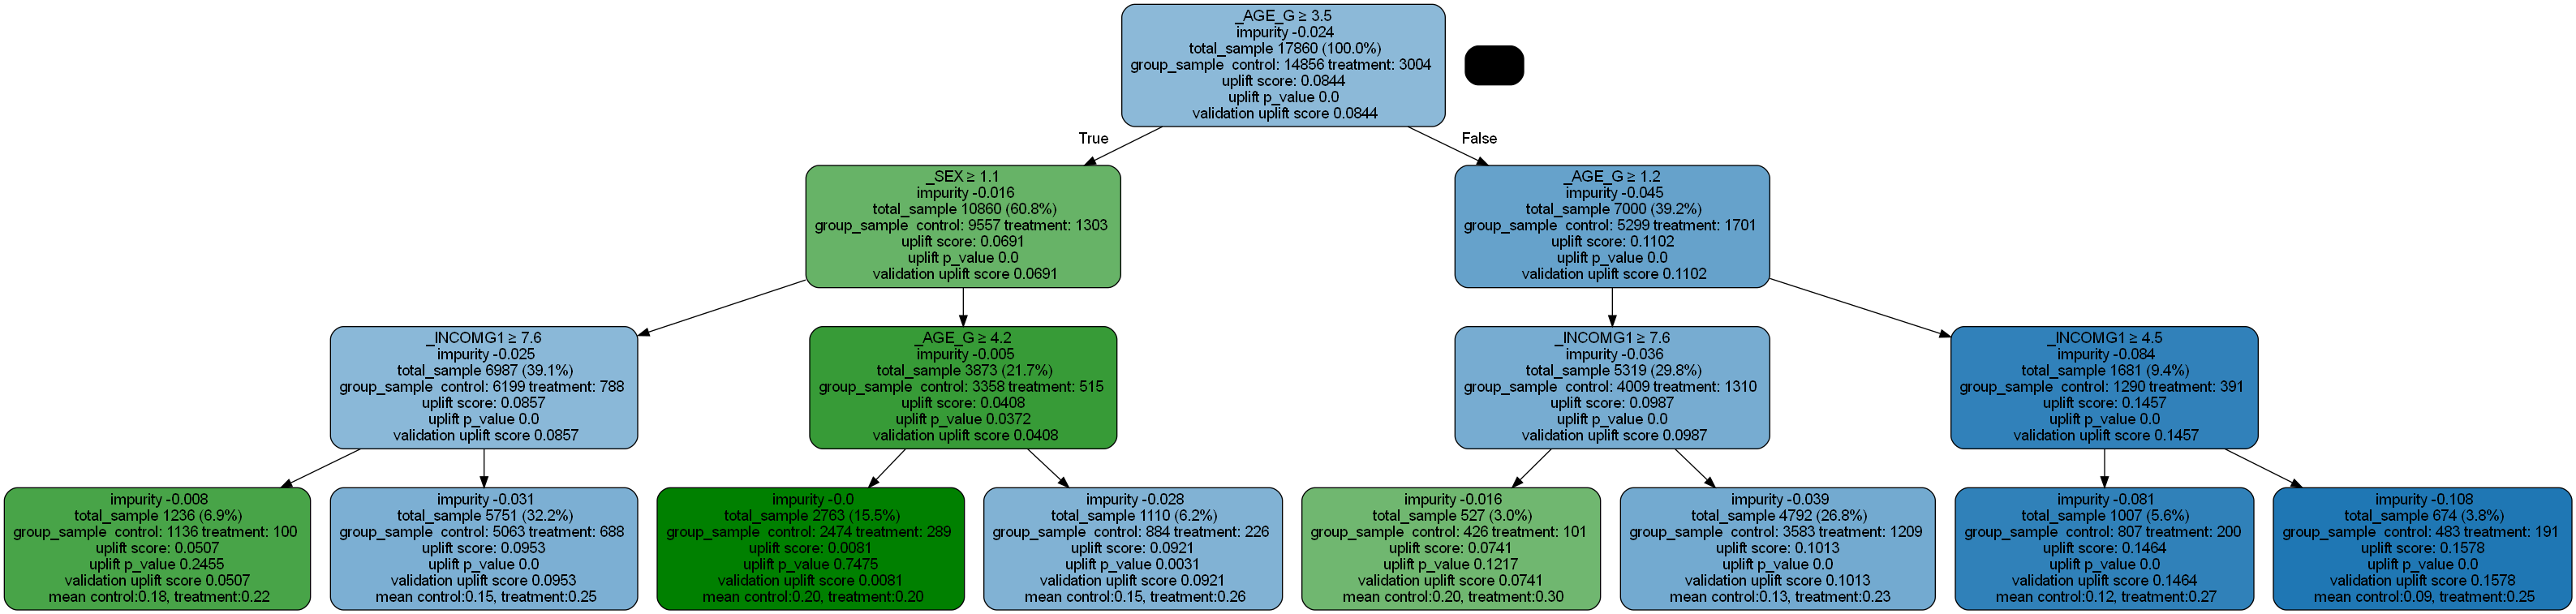

In [40]:
features_list = ['_AGE_G', '_SEX', '_EDUCAG', '_INCOMG1']
treatment = 'ACEDRUGS'
outcome = 'MENTHLTH'
#For ACEDRUGS, the control grouop is people who didn't live with anyone using illicit drugs, which corresponds to a value of 2. The threshold of mental health days was arbitrarily chosen to be 30
processed_ace_train= preprocess_data(ace_train, treatment, outcome, control_group_name=2, treatment_group_name=1, outcome_threshold=30)
processed_ace_test= preprocess_data(ace_test, treatment, outcome, control_group_name=2, treatment_group_name=1, outcome_threshold=30)
uplift_model = model_uplift_tree(processed_ace_train, processed_ace_test,treatment, outcome, features_list)
# #Visualize the tree with training data
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,features_list)
draw_graph=graph.write_png(treatment+"_"+outcome+"_training.png")
Image(graph.create_png())

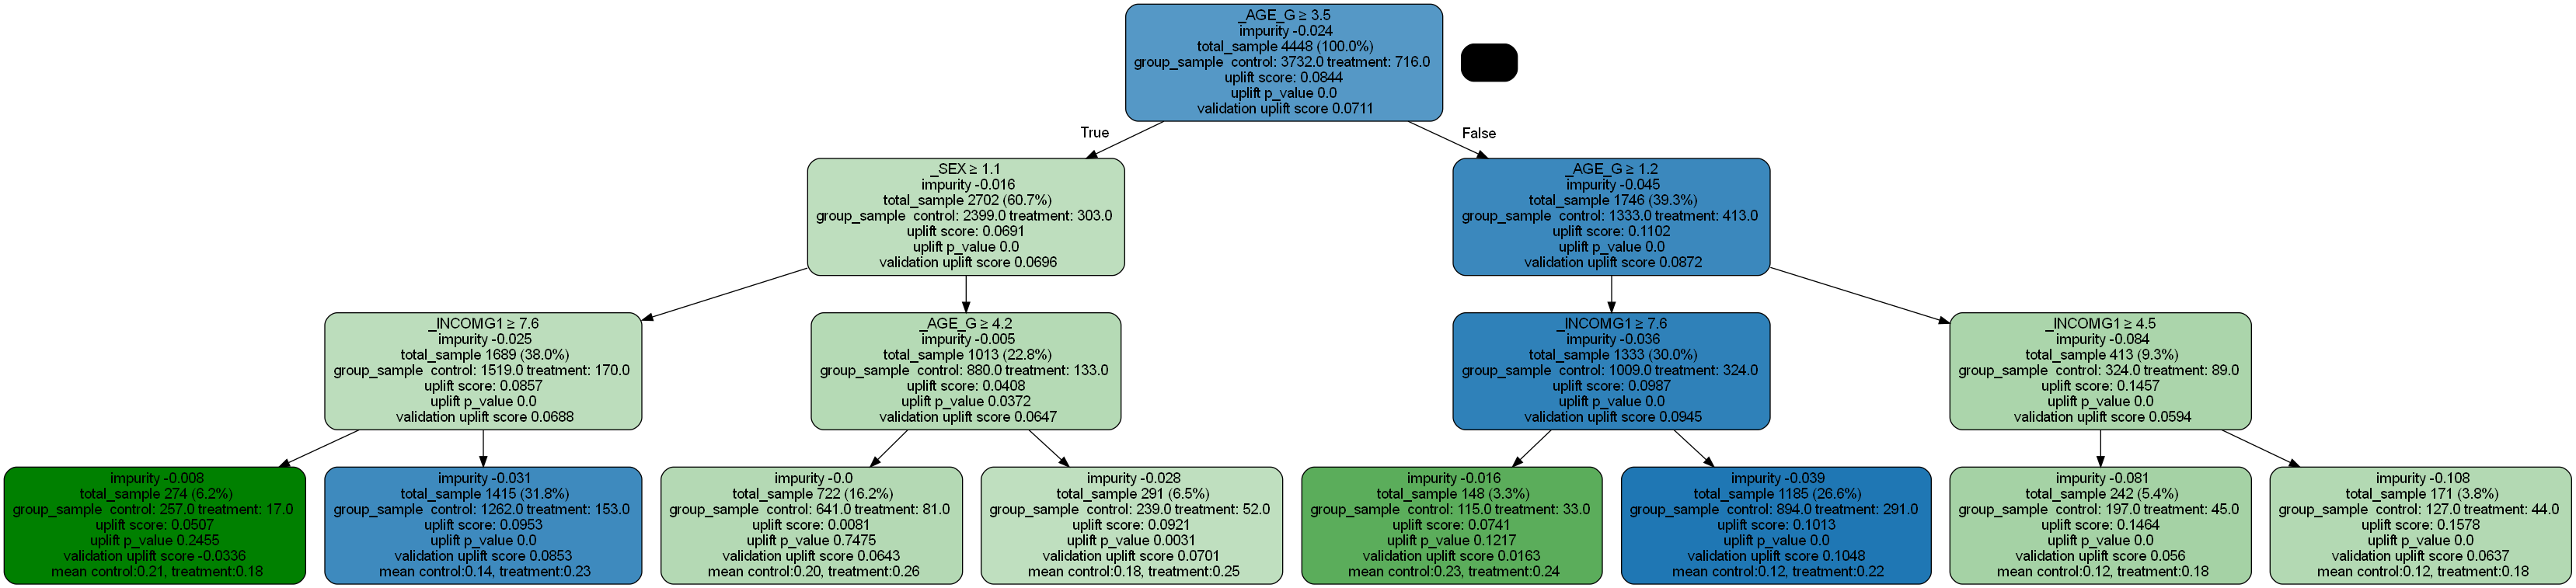

In [41]:
uplift_model.fill(X=processed_ace_test[features_list].values, treatment=processed_ace_test[treatment].values, y=processed_ace_test[outcome].values)
# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,features_list)
draw_graph=graph.write_png(treatment+"_"+outcome+"_validation.png")
Image(graph.create_png())

In [42]:
y_pred = uplift_model.predict(processed_ace_test[features_list].values)
df_predictions = pd.DataFrame(y_pred, columns=uplift_model.classes_)


In [43]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((df_predictions < 0).all(axis=1),
                           'control',
                           df_predictions.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(processed_ace_test[treatment] == best_treatment, 1, 0)
actual_is_control = np.where(processed_ace_test[treatment] == 'control', 1, 0)

In [44]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = df_predictions[synthetic]

In [45]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             conversion = processed_ace_test.loc[synthetic, outcome].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_[1:])))




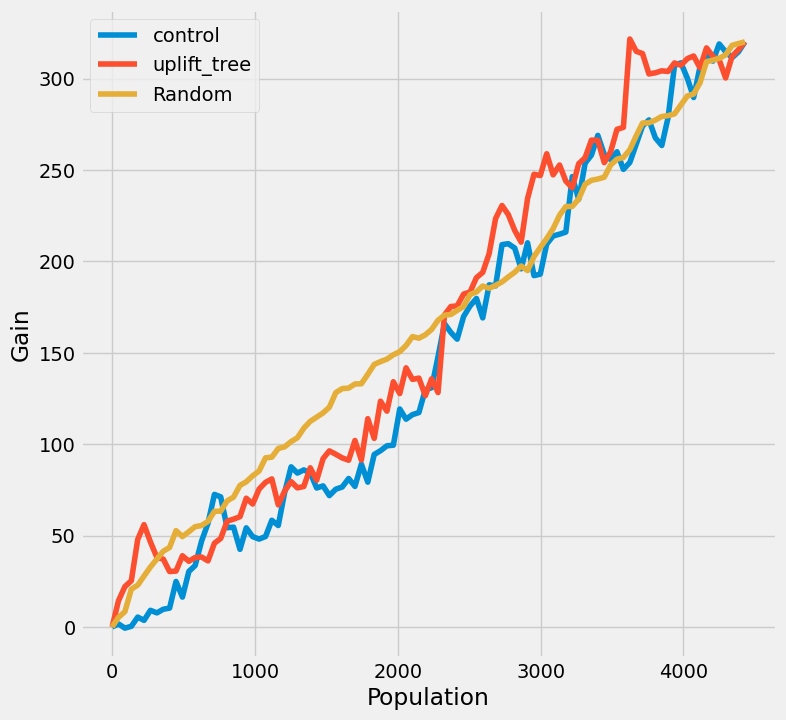

In [47]:
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')